### Imports

In [1]:
%matplotlib inline
import gdax
from api_key import *
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import time
from pprint import pprint

### Function Definitions

In [2]:
def get_value_df(client):
    df = get_history_df(client,
                        get_account_df(client))
    holdings = get_holdings(df)
    holdings['price'] = [client.get_product_ticker(row.product_id)['price'] for i, row in holdings.iterrows()]
    holdings['price'] = pd.to_numeric(holdings['price'])
    holdings['value'] = holdings['price'] * holdings['amount']
    holdings['abs_gain'] = holdings['payment'] + holdings['value']
    holdings['gain_rate'] = (holdings['abs_gain'] / (-holdings['payment'])) * 100
    return holdings

def cols2nums(df, column_names):
    try:
        for c in column_names:
            df[c] = pd.to_numeric(df[c])
    except KeyError:
        pass
    return df

def cols2datetimes(df, column_names):
    try:
        for c in column_names:
            df[c] = pd.to_datetime(df[c])
    except KeyError:
        pass
    return df

def get_account_df(client):
    accounts = pd.DataFrame(auth_client.get_accounts())
    accounts = accounts.set_index('currency')
    num_cols = ['available', 'balance', 'hold']
    accounts = cols2nums(accounts, num_cols)
    return accounts

def get_history_df(client, account_df):
    # Get history from api
    hist = {acc: client.get_account_history(row['id'])[0] for acc, row in account_df.iterrows()}
    
    # Convert to dataframes
    hist = {acc: pd.DataFrame(hist[acc]) for acc in hist}
    
    # Drop dataframes with no history
    hist = {acc: hist[acc] for acc in hist if not hist[acc].empty}
    
    # Convert numeric columns
    num_cols = ['amount', 'balance']
    hist = {acc: cols2nums(hist[acc], num_cols) for acc in hist}
    
    # Convert to datetimes and index by that
    date_cols = ['created_at']
    hist = {acc: cols2datetimes(hist[acc], date_cols) for acc in hist}
    hist = {acc: hist[acc].set_index(date_cols[0]) for acc in hist}
    
    # Convert into a single multi-indexed dataframe
    df = pd.concat([hist[acc] for acc in hist],
               keys=list(hist.keys()))
    
    # Expand the details column
    df = pd.concat([df.drop(['details'], axis=1), df['details'].apply(pd.Series)], axis=1)
    
    # Add the payment column
    df = payment_col(df)
    return df

def payment_col(df):
    holdings = get_holdings(df)
    holdings['payment'] = [findpayment(df, row) for i, row in holdings.iterrows()]
    df['payment'] = holdings['payment']
    return df

def get_holdings(df):
    holdings = df.drop('USD', level=0)
    holdings = holdings[holdings['amount'] > 0]
    return holdings

def findpayment(df, holding):
    payments = df.loc['USD'][df.loc['USD']['amount'] < 0]
    payments = payments[payments.trade_id == holding.trade_id]
    return payments.amount.sum()

def time_series(start, end, n):
    # Like range(), but for time series
    t = end - start
    s = t.total_seconds() / n
    dt = timedelta(seconds=s)
    res = [start]
    for i in range(n-1):
        res.append(res[-1] + dt)
    res.append(end)
    return res

def get_value_history(product, start, n, end=None):
    if end is None:
        end = datetime.now()
    times = time_series(start, end, n)
    
    gran = (end - start).total_seconds() / n
    values = auth_client.get_product_historic_rates(product,
                                                    granularity=gran,
                                                    start=start.isoformat(),
                                                    end=end.isoformat())
    df = pd.DataFrame(values)
    df.columns = ['time', 'low', 'high', 'open', 'close', 'volume']
    df['time'] = df['time'].apply(datetime.fromtimestamp)
    df = df.set_index('time')
    return df

def get_performance_history(holding_row):
    # Gets a
    df = get_value_history(holding_row.product_id, holding_row.name[1], 200)
    df = df * holding_row.amount
    return df

### Login to GDAX

In [3]:
auth_client = gdax.AuthenticatedClient(KEY,
                                       B64SECRET,
                                       PASSPHRASE)

### Get Account Balances

In [4]:
dfacc = get_account_df(auth_client)
dfacc

,available,balance,hold,id,profile_id
currency,,,,,
USD,0.500056,0.500056,0.0,b515a01b-0a24-41bb-b78f-665816215046,149da018-97df-4526-be06-c6c49a48841f
BTC,0.005663,0.005663,0.0,b5750698-0078-4370-a169-7451e424b11a,149da018-97df-4526-be06-c6c49a48841f
LTC,0.000000,0.000000,0.0,819c8e13-2031-402c-af46-90cdfe4dad57,149da018-97df-4526-be06-c6c49a48841f
ETH,0.125000,0.125000,0.0,97212e94-3f21-48fd-a9dd-f88a8dfbde83,149da018-97df-4526-be06-c6c49a48841f
BCH,0.000000,0.000000,0.0,3cd75c2b-8e42-4c35-b741-59f211c06ed9,149da018-97df-4526-be06-c6c49a48841f


### Get account histories

In [5]:
dfhist = get_history_df(auth_client, dfacc)
dfhist

amount     balance         id      type  \
    created_at                                                                
USD 2017-12-20 00:14:53.193794 -100.000000    0.500056  542846699     match   
    2017-12-19 22:37:14.513654   -0.248130  100.500056  542506285       fee   
    2017-12-19 22:37:14.513654  -99.251814  100.748186  542506283     match   
    2017-12-16 02:19:20.795840  100.000000  200.000000  518438320  transfer   
    2017-12-15 19:10:11.993755  100.000000  100.000000  517409156  transfer   
BTC 2017-12-19 22:37:14.513654    0.005663    0.005663  542506282     match   
ETH 2017-12-20 00:14:53.193794    0.125000    0.125000  542846698     match   

                                                            order_id  \
    created_at                                                         
USD 2017-12-20 00:14:53.193794  e51fee2c-48ff-4c31-b20d-4a917c887cfd   
    2017-12-19 22:37:14.513654  d5b23cab-4414-48ee-9d2d-4d3c599e14fc   
    2017-12-19 22:37:14.513654  d5b23cab-4414-48ee-9d2d-4d3c599e14fc   
    2017-12-16 02:19:20.795840                                   NaN   
    2017-12-15 19:10:11.993755                                   NaN   
BTC 2017-12-19 22:37:14.513654  d5b23cab-4414-48ee-9d2d-4d3c599e14fc   
ETH 2017-12-20 00:14:53.193794  e51fee2c-48ff-4c31-b20d-4a917c887cfd   

                               product_id  trade_id  \
    created_at                                        
USD 2017-12-20 00:14:53.193794    ETH-USD  22481382   
    2017-12-19 22:37:14.513654    BTC-USD  29043690   
    2017-12-19 22:37:14.513654    BTC-USD  29043690   
    2017-12-16 02:19:20.795840        NaN       NaN   
    2017-12-15 19:10:11.993755        NaN       NaN   
BTC 2017-12-19 22:37:14.513654    BTC-USD  29043690   
ETH 2017-12-20 00:14:53.193794    ETH-USD  22481382   

                                                         transfer_id  \
    created_at                                                         
USD 2017-12-20 00:14:53.193794                                   NaN   
    2017-12-19 22:37:14.513654                                   NaN   
    2017-12-19 22:37:14.513654                                   NaN   
    2017-12-16 02:19:20.795840  01e81d9b-e2c2-49b7-aa3d-5bce23d37079   
    2017-12-15 19:10:11.993755  7edea862-99f4-4c39-93bb-e81c68c2e676   
BTC 2017-12-19 22:37:14.513654                                   NaN   
ETH 2017-12-20 00:14:53.193794                                   NaN   

                               transfer_type     payment  
    created_at                                            
USD 2017-12-20 00:14:53.193794           NaN         NaN  
    2017-12-19 22:37:14.513654           NaN         NaN  
    2017-12-19 22:37:14.513654           NaN         NaN  
    2017-12-16 02:19:20.795840       deposit         NaN  
    2017-12-15 19:10:11.993755       deposit         NaN  
BTC 2017-12-19 22:37:14.513654           NaN  -99.499944  
ETH 2017-12-20 00:14:53.193794           NaN -100.000000

### Get current values

In [6]:
holdings = get_value_df(auth_client)
holdings

,,amount,balance,id,type,order_id,product_id,trade_id,transfer_id,transfer_type,payment,price,value,abs_gain,gain_rate
,created_at,,,,,,,,,,,,,,
BTC,2017-12-19 22:37:14.513654,0.005663,0.005663,542506282,match,d5b23cab-4414-48ee-9d2d-4d3c599e14fc,BTC-USD,29043690,NaN,NaN,-99.499944,14568.04,82.49983,-17.000114,-17.085551
ETH,2017-12-20 00:14:53.193794,0.125000,0.125000,542846698,match,e51fee2c-48ff-4c31-b20d-4a917c887cfd,ETH-USD,22481382,NaN,NaN,-100.000000,703.97,87.99625,-12.003750,-12.003750


Text(0.5,1,'BTC')

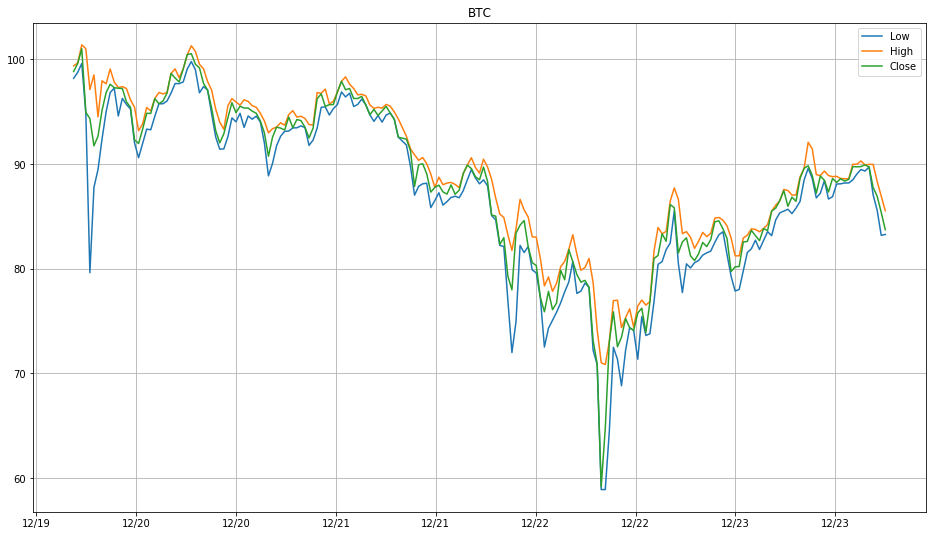

In [7]:
h = holdings.iloc[0]
df = get_performance_history(h)
fig, ax = plt.subplots(figsize=(16, 9))
ax.grid(True)
ax.plot(df['low'])
ax.plot(df['high'])
ax.plot(df['close'])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax.legend(['Low', 'High', 'Close'])
ax.set_title(h.name[0])